# WGAN-GP with DCGAN layers
Code is mainly based upon the DCGAN implementation in the TensorFlow tutorials

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
#import memory_saving_gradients
# monkey patch tf.gradients to point to our custom version, with automatic checkpoint selection
#tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import librosa
import os
import functools
import subprocess
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
#import imageio
import simpleaudio as sa
import math
import gc
from IPython import display
import time
import scipy.io.wavfile as wavfile
from IPython.display import clear_output, Image, display, HTML
from tensorflow.layers import dense, flatten
from tensorflow.nn import relu, leaky_relu
from tensorflow import tanh
from tensorflow.image import ResizeMethod

resize_images = lambda x, size: tf.transpose(tf.image.resize_images(tf.transpose(x, [0, 2, 3, 1]), size, method=ResizeMethod.NEAREST_NEIGHBOR), [0, 3, 1, 2])
conv2d_transpose = functools.partial(tf.layers.conv2d_transpose, padding='same', data_format='channels_first')
conv2d = functools.partial(tf.layers.conv2d, padding='same', data_format='channels_first')
batch_norm = functools.partial(tf.layers.batch_normalization, axis=1)
layer_norm = lambda x: tf.transpose(tf.contrib.layers.layer_norm(tf.transpose(x, [0, 2, 3, 1])), [0, 3, 1, 2])
pool = functools.partial(tf.nn.pool, window_shape=(2, 2), pooling_type='AVG', padding='SAME', data_format='NCHW')

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

run_options = tf.RunOptions(report_tensor_allocations_upon_oom=True)

sess = tf.Session(config=config)

In [3]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Hyperparameters

In [4]:
# Number for large nsynth-train dataset
TOTAL_NUM = 102165
# Number for small nsynth-test dataset
# TOTAL_NUM = 1689
BUFFER_SIZE = 2048
BATCH_SIZE = 20
PREFETCH_BUFFER_SIZE = BATCH_SIZE
# EPOCHS = 150
LAMBDA = 10
ALPHA = 0.0002
BETA1 = 0.5
BETA2 = 0.999
CRITIC_UPDATES_PER_GEN_UPDATE = 5
noise_dim = 100
num_examples_to_generate = 16
padded_spec_dim = (1, 512, 256)
spec_dim = (1, 512, 251)

# Make a dataset using TensorFlow's input pipeline

In [5]:
# Reading features of TFRecord file
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'spectrogram': tf.FixedLenFeature([257024], dtype=tf.float32),
    #'spectrogram': tf.FixedLenFeature([128512], dtype=tf.float32),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}

# Defining models and training
`buildgraph()` was largely based upon Zardinality's WGAN implementation and was extensively modified using the code from the paper introducing WGAN-GP

In [6]:
def generate_images(epoch=None, source='fake', save=True):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    assert not(epoch is None) or not(save)
    
    if(source=='fake'):
        disp_images = sess.run(generated)
    elif(source=='real'):
        disp_images = sess.run(images)
    else:
        raise ValueError
    fig = plt.figure(figsize=(4,4))
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, 0, :, :] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    if(save):
        plt.savefig('images/image_at_epoch_{:.2f}.png'.format(epoch))
    plt.show()

In [7]:
def residBlockUpscale(num, x, num_filters, filter_size=4, strides=(2, 2), 
                      num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-upscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = resize_images(x, (x.shape[2]*strides[0], x.shape[3]*strides[1]))
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = resize_images(x, (x.shape[2]*strides[0], x.shape[3]*strides[1]))
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, num_filters, filter_size, 1)
        x = x_orig + x
        return x

def residBlockDownscale(num, x, num_filters, filter_size=4, strides=(2, 2), 
                        num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-downscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = pool(x, window_shape=strides)
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = pool(x)
        x = x_orig + x
        return x

In [8]:
def generator(x, training=True):
    # Input x is noise vector
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        # x_orig = tf.transpose(tf.image.resize_bicubic(tf.transpose(x, [0, 2, 3, 1]), 512*256), [0, 3, 1, 2])
        x = dense(x, 32*32*16)
        x = tf.reshape(x, shape = (-1, 32, 32, 16))
        # Shape: 32x16
        x = residBlockUpscale(1, x, 32, training=training)
        # Shape: 64x32
        x = residBlockUpscale(2, x, 16, training=training)
        # Shape: 128x64
        x = residBlockUpscale(3, x, 8, training=training)
        # Shape: 256x128
        x = residBlockUpscale(4, x, 4, training=training)
        # Shape: 512x256
        # x = x_orig + x
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, 1, 4, 1)
        x = tanh(x)
        x = x[:, :, :, 0:251]
        return x
    
def critic(x, training=True):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE):
        x = conv2d(x, 4, 4, 1)
        x = residBlockDownscale(1, x, 4, training=training)
        x = residBlockDownscale(2, x, 8, training=training)
        x = residBlockDownscale(3, x, 16, training=training)
        x = residBlockDownscale(4, x, 32, strides=(1, 1), training=training)
        x = flatten(x)
        x = dense(x, 1)
        return x

In [9]:
def buildgraph():
    with tf.variable_scope('epoch-logging'):
        epochs = tf.Variable(0.0, trainable=True, use_resource=True, dtype=tf.float64)
        increment = tf.placeholder(tf.float64)
        ranEpoch = tf.assign(epochs, tf.cast(tf.round((epochs + increment)*tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64))/tf.cast(tf.pow(10, tf.cast(np.floor(np.log10(TOTAL_NUM))+2, tf.int32)), tf.float64), tf.float64))
        getEpoch = epochs
        global_step = tf.Variable(0, trainable=False, dtype=tf.int32, name='global-step')
    
    with tf.variable_scope('input-pipeline'):
        specs = tf.data.TFRecordDataset("spectrograms.tfrecord")
        specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
        # specs = specs.map(map_func=(lambda raw_data: tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], spec_dim)), num_parallel_calls=-1)
        specs = specs.map(map_func=(lambda raw_data: tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'][0:128512], (1, 512, 251))), num_parallel_calls=-1)
        specs = specs.batch(batch_size=BATCH_SIZE)
        specs = specs.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
        iterator = specs.make_one_shot_iterator()
        real_images = iterator.get_next()
    
    with tf.variable_scope('runs'):
        noise = tf.random_normal([BATCH_SIZE, noise_dim])
        fake_images = generator(noise)
        critic_real = critic(real_images)
        critic_fake = critic(fake_images)
        # keeping the random vector constant for generation (prediction) so
        # it will be easier to see the improvement of the gan.
        random_vector_for_generation = tf.Variable(tf.random_normal([num_examples_to_generate, noise_dim]), trainable=False, name='constant-latent-space')
        test_images = generator(random_vector_for_generation, training=False)
    
    with tf.variable_scope('costs'):
        gen_cost = -tf.reduce_mean(critic_fake)
        critic_cost_naive = tf.reduce_mean(critic_fake)-tf.reduce_mean(critic_real)
        tf.summary.scalar('critic-cost-no-gp', tf.reduce_mean(critic_cost_naive))
        tf.summary.scalar('generator-cost', tf.reduce_mean(gen_cost))

        with tf.variable_scope('gradient-penalty'):
            alpha = tf.random_uniform(shape=[BATCH_SIZE, spec_dim[0], spec_dim[1], spec_dim[2]], minval=0., maxval=1.)
            differences = fake_images-real_images
            interpolates = real_images+(alpha*differences)
            gradients = tf.gradients(critic(interpolates), [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes-1.)**2)
            critic_cost = critic_cost_naive + LAMBDA*gradient_penalty
            tf.summary.scalar('critic-cost-with-gp', tf.reduce_mean(critic_cost))
    
    with tf.variable_scope('optimizers'):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            gen_opt = tf.train.AdamOptimizer(ALPHA, BETA1, BETA2).minimize(gen_cost, global_step=global_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/generator'))
            critic_opt = tf.train.AdamOptimizer(ALPHA, BETA1, BETA2).minimize(critic_cost, global_step=global_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/critic'))
    
    merged = tf.summary.merge_all()
    
    return generator, gen_opt, critic_opt, real_images, test_images, ranEpoch, getEpoch, increment, merged, global_step

In [10]:
def train(batch, epochs, noise_dim, gen_opt, critic_opt, images):  
    for epoch in range(epochs):
        start = time.time()
        runOneEpoch(batch, noise_dim, gen_opt, critic_opt, images)
        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                          time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_images(generator,
                           -1,
                           random_vector_for_generation)
    
def runOneEpoch(gen_opt, critic_opt, getEpoch, increment, ranEpoch, epoch_proportion=1):
    start = time.time()
    for num in range(math.ceil(epoch_proportion*TOTAL_NUM/BATCH_SIZE)):
        if(num % (CRITIC_UPDATES_PER_GEN_UPDATE+1) == 0):
            sess.run(gen_opt, options=run_options) #, feed_dict={images: sess.run(batch)})
        else:
            sess.run(critic_opt, options=run_options) #, feed_dict={images: sess.run(batch)})
        gc.collect()
        print("Finished {} out of {}".format(num*BATCH_SIZE+BATCH_SIZE, 
                                             math.ceil(epoch_proportion*TOTAL_NUM)), end='\r')
    clear_output(wait=True)
    sess.run(ranEpoch, feed_dict={increment: epoch_proportion})
    writer.add_summary(sess.run(merged), tf.train.global_step(sess, global_step))
    print("Finished epoch {:.2f}".format(sess.run(getEpoch)))
    generate_images(sess.run(getEpoch))
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken {} sec'.format(time.time()-start))

In [11]:
def testAudio(batch, prefix):
    specs = sess.run(batch)
    for i in range(specs.shape[0]):
        spec = specs[i]
        mag = spec[:, :, 0]
        angles = spec[:, :, 1]
        mag = ((mag+1)/2)*48-32
        angles = angles*math.pi
        ft =(np.exp(mag)-1.2664166e-14)*np.exp(1j*angles)
        newaudio = librosa.istft(ft, 512, 2048).astype(np.int16)
        #print('Generated audio')
        #print('Interval of audio: [{}, {}]'.format(np.amin(newaudio), np.amax(newaudio)))
        wavfile.write("audio/{}-{}.wav".format(prefix, i), 16000, newaudio)

# Running the model

In [12]:
generator, gen_opt, critic_opt, images, generated, ranEpoch, getEpoch, increment, merged, global_step = buildgraph()
writer = tf.summary.FileWriter('/tmp/tensorboard/log/', sess.graph)
sess.run(tf.global_variables_initializer())

In [13]:
saver = tf.train.Saver(var_list=tf.trainable_variables())
if(not(os.path.isdir("checkpoints"))):
#if(True):
    saver.save(sess, "checkpoints/model-mag-only")
    print("Saved")
else:
    while True:
        ans = input("Checkpoint already exists. Want to overwrite? (y/n): ")
        if(ans == "y"):
            saver.save(sess, "checkpoints/model-mag-only")
            break
        elif(ans != "n"):
            print("Invalid response, please type \"y\" or \"n\"")
        else:
            break

sess.graph.finalize()

Checkpoint already exists. Want to overwrite? (y/n): y


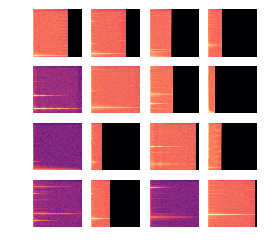

In [15]:
generate_images(source='real', save=False)

Finished epoch 2.58


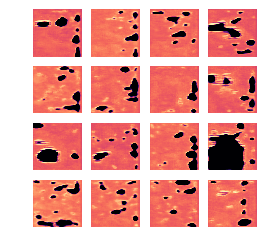

Time taken 179.36037731170654 sec


In [ ]:
# Can exit any time because model saves after every epoch
try:
    saver.restore(sess, "checkpoints/model-mag-only")
except: 
    traceback.print_exc()
    while True:
        ans = input("Saved checkpoint invalid, save new checkpoint? (y/n): ")
        if(ans == "y"):
            saver.save(sess, "checkpoints/model-mag-only")
            break
        elif(ans != "n"):
            print("Invalid response, please type \"y\" or \"n\"")
        else:
            raise Exception('Checkpoint invalid')

# Waits for another program to remove the .lock file before continuing execution
!rm .lock
# Comment out next line to disable lock
# !touch .lock
while(subprocess.check_output('test -f .lock ; echo $?', shell=True).decode('utf-8')[0]=='0'):
    time.sleep(5)
print('Unlocked', end='\r')

while True:
        runOneEpoch(gen_opt, critic_opt, getEpoch, increment, ranEpoch, 0.01)
        saver.save(sess, "checkpoints/model-mag-only")

In [ ]:
print(sess.run(images).shape)

In [ ]:
testAudio(images, "real")
testAudio(generated, "fake")

In [ ]:
while(kernel is dead):
    plant_a_new_seed()